 # Table of Contents
<div class="toc" style="margin-top: 1em;"><ul class="toc-item" id="toc-level0"><li><span><a href="http://localhost:8887/notebooks/keras/new_inout.ipynb#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="http://localhost:8887/notebooks/keras/new_inout.ipynb#Check-model-predictions" data-toc-modified-id="Check-model-predictions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Check model predictions</a></span><ul class="toc-item"><li><span><a href="http://localhost:8887/notebooks/keras/new_inout.ipynb#Visualize-random-predictions" data-toc-modified-id="Visualize-random-predictions-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Visualize random predictions</a></span></li><li><span><a href="http://localhost:8887/notebooks/keras/new_inout.ipynb#X-Y-slices-of-precipitation-and-OLR" data-toc-modified-id="X-Y-slices-of-precipitation-and-OLR-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>X-Y slices of precipitation and OLR</a></span></li></ul></li><li><span><a href="http://localhost:8887/notebooks/keras/new_inout.ipynb#Animations" data-toc-modified-id="Animations-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Animations</a></span></li></ul></div>

# Predictions with new input/output variables

Some visualization again for the predictions with 
- Inputs: [TAP, QAP, dTdt_adiabatic, dQdt_adiabatic, SHFLX, LHFLX, SOLIN] —> 87 vars
- Outputs: [SPDT, SPDQ, QRL, QRS, PRECT, FLUT] —> 86 vars

## Setup

In [12]:
# Imports 
from importlib import reload
import utils; reload(utils); from utils import *
import data_generator; reload(data_generator); from data_generator import *
import models; reload(models); from models import *

In [2]:
# Limit Tensorflow GPU memory usage. 
# Note that it's not possible to change the allocation or release memory again.
config = tf.ConfigProto()
config.gpu_options.allow_growth = True   # Allocates as much memory as needed.
keras.backend.tensorflow_backend.set_session(tf.Session(config=config))

In [3]:
from keras.utils.generic_utils import get_custom_objects
metrics_dict = dict([(f.__name__, f) for f in metrics])
get_custom_objects().update(metrics_dict)

In [4]:
# Plotting setup
%matplotlib inline
np.random.seed(42)
sns.set_style('dark')
sns.set_palette('deep')
sns.set_context('talk')
plt.rcParams["figure.figsize"] = (10,7)

In [5]:
# Define data paths
data_dir = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/preprocessed_data/SOLIN/' # Full dataset
%ls $data_dir

SPCAM_mean_detailed.nc              SPCAM_outputs_valid_by_lon_flat.nc
SPCAM_outputs_detailed.nc           SPCAM_std_detailed.nc
SPCAM_outputs_train_by_lon_flat.nc


In [6]:
# Define a dictionary containing the feature and target variables
# and the number of dimensions
feature_vars = OrderedDict({
    'TAP': 2,             # Temperature [z, sample]
    'QAP': 2,             # Specific humidity [z, sample]
    'dTdt_adiabatic': 2,  # [z, sample]
    'dQdt_adiabatic': 2,  # [z, sample]
    'SHFLX': 1,           # [sample]
    'LHFLX': 1,           # [sample]
    'SOLIN': 1,
})
target_vars = OrderedDict({
    'SPDT': 2,            # SP temperature tendency [z, sample]
    'SPDQ': 2,            # SP humidity tendency [z, sample]
    'QRL': 2,
    'QRS': 2,
    'PRECT': 1,
    'FLUT': 1,
})

## Check model predictions

In [7]:
# Load the dataset
valid_set_lon = DataSet(data_dir, 'SPCAM_outputs_valid_by_lon_flat.nc', 'SPCAM_mean_detailed.nc',
                        'SPCAM_std_detailed.nc', feature_vars.keys(), flat_input=True,
                        target_names=target_vars.keys())

In [10]:
model = keras.models.load_model('./models/fc_1024_1024_512_512_by_lon_SOLIN.h5')

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              90112     
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_3 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_5 (Dense)              (None, 86)                44118     
Total params: 1,971,286
Trainable params: 1,971,286
Non-trainable params: 0
_________________________________________________________________


In [13]:
preds = model.predict(valid_set_lon.features, batch_size=1024)

### Visualize random predictions

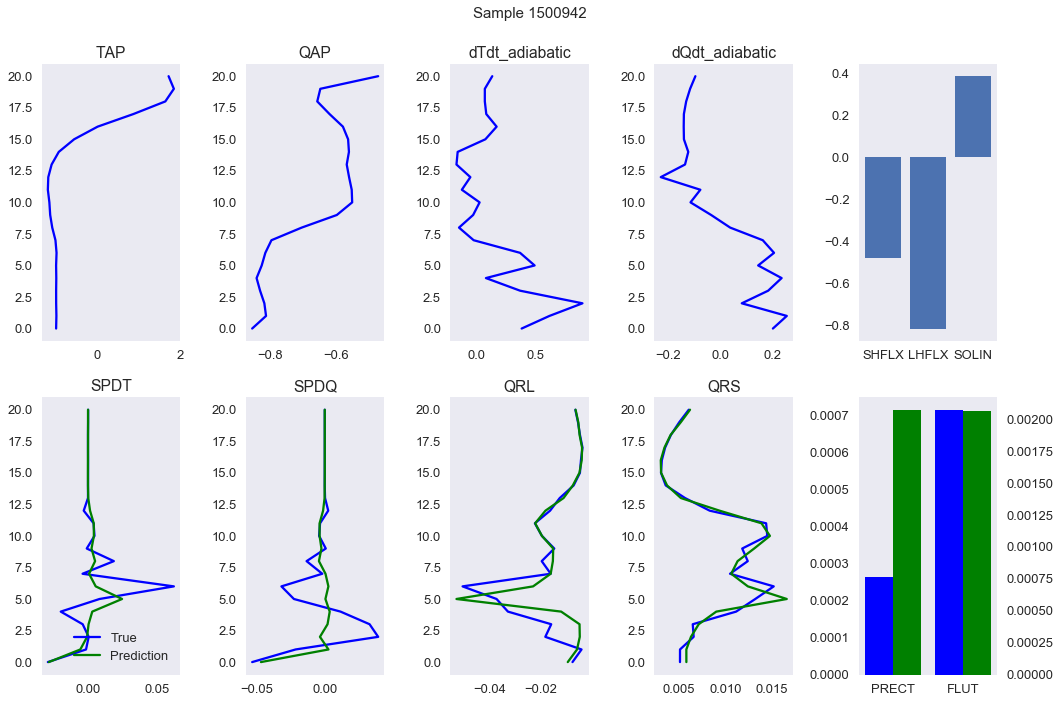

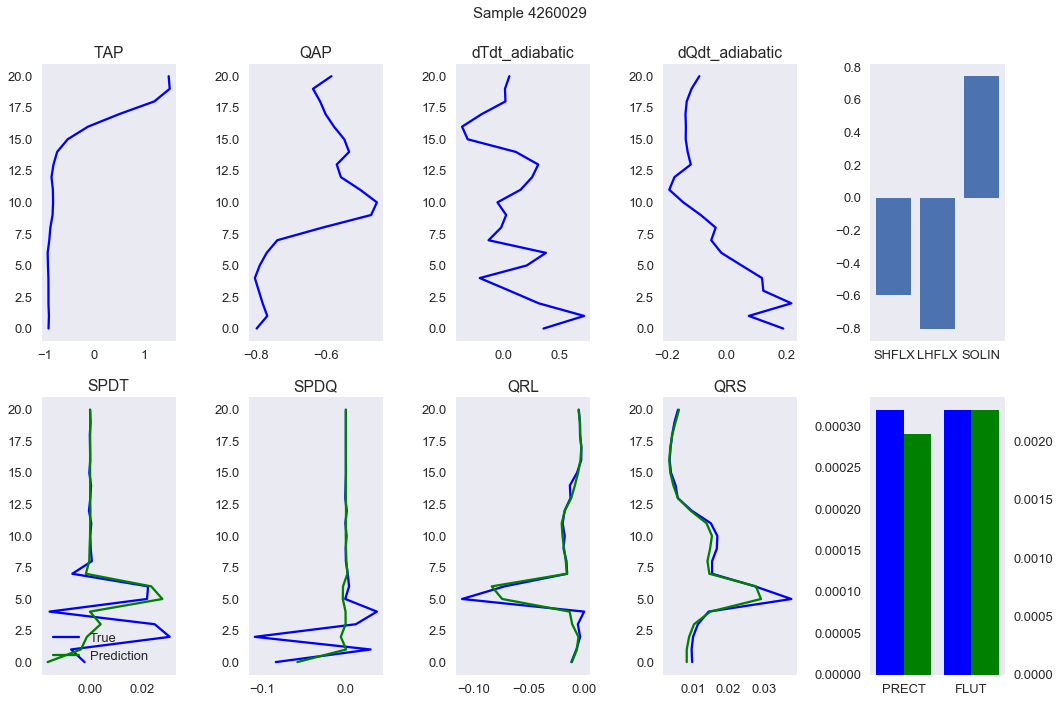

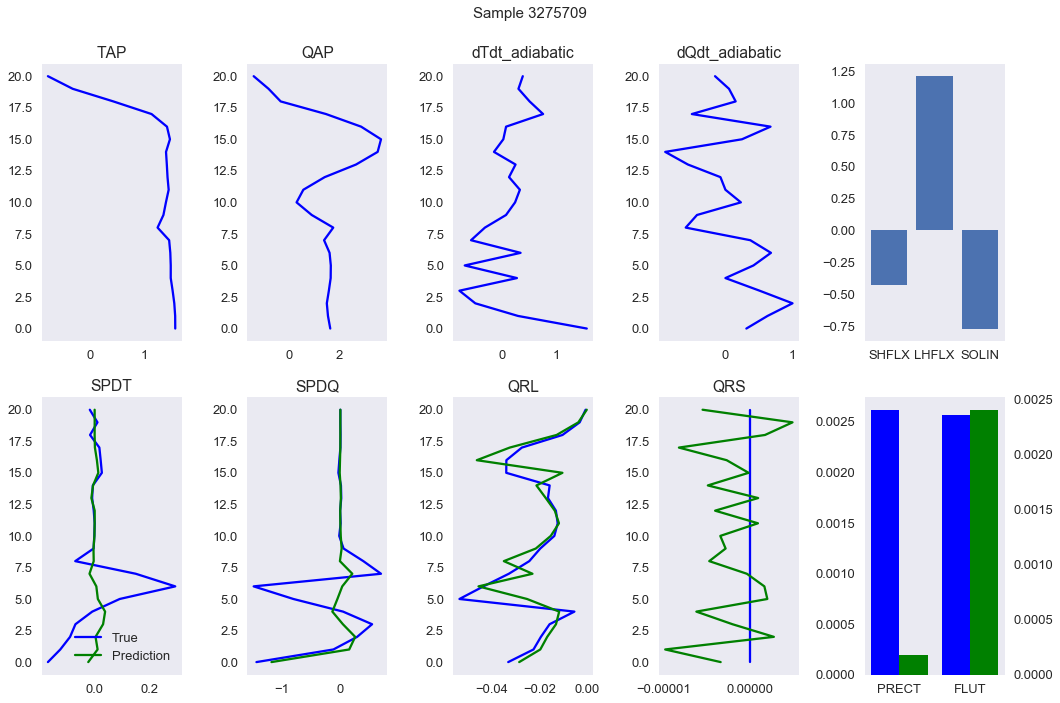

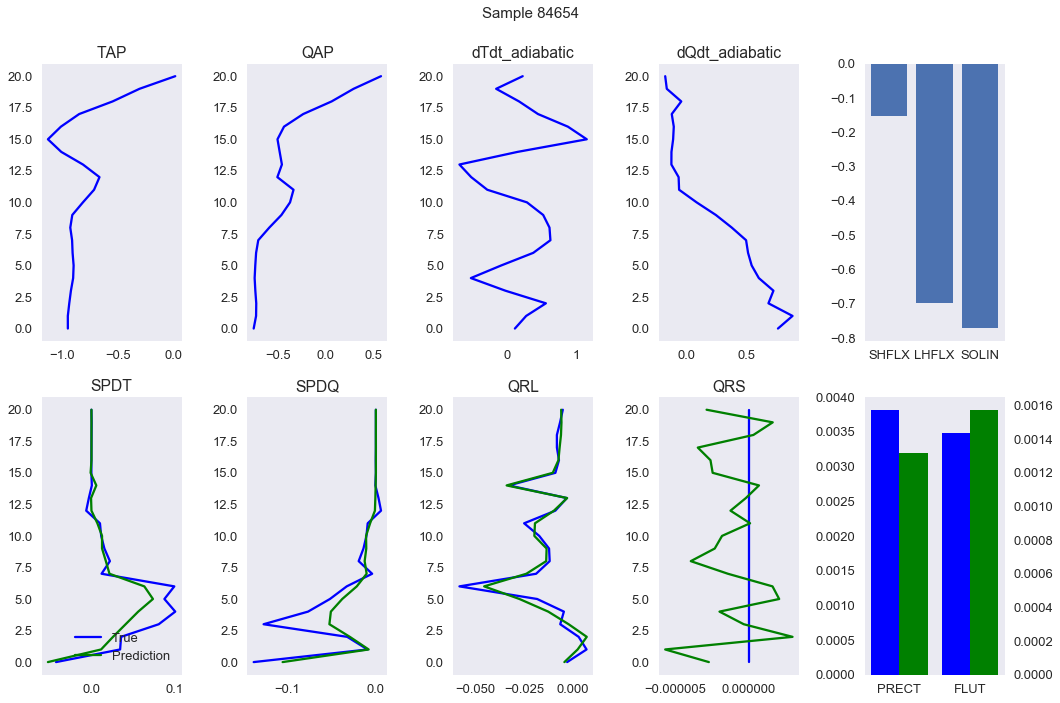

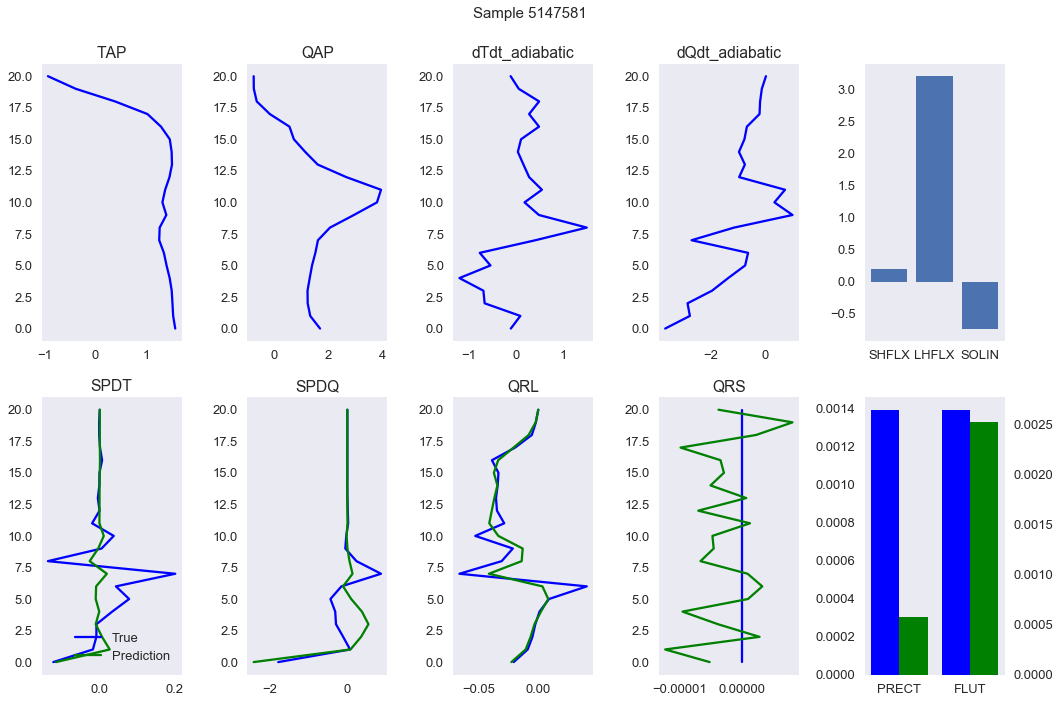

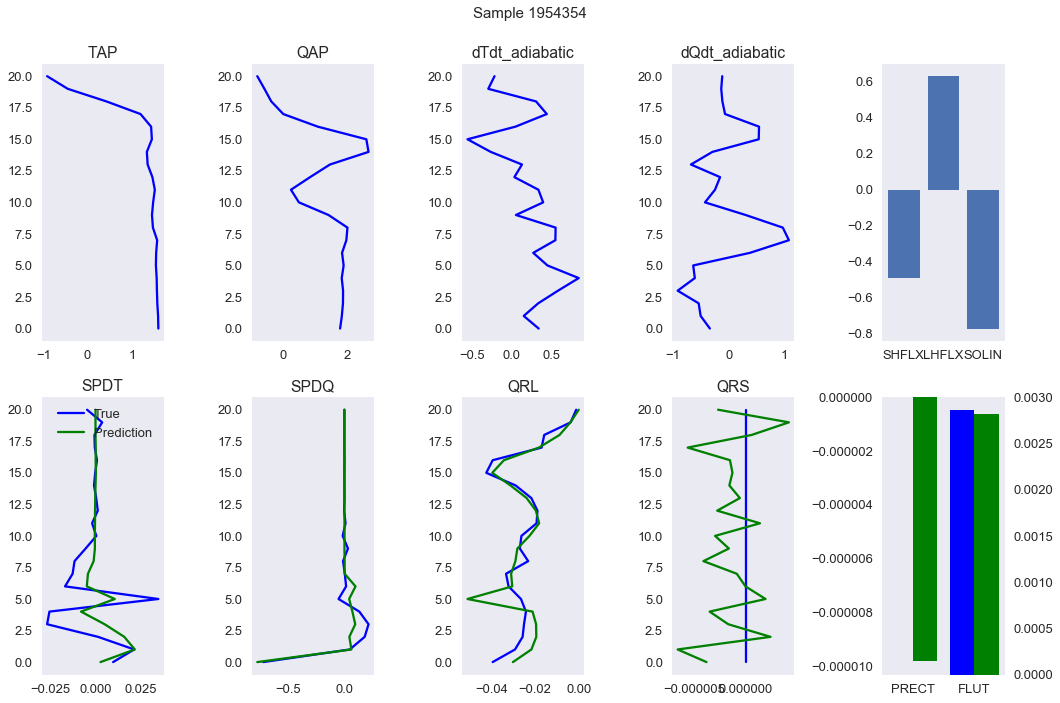

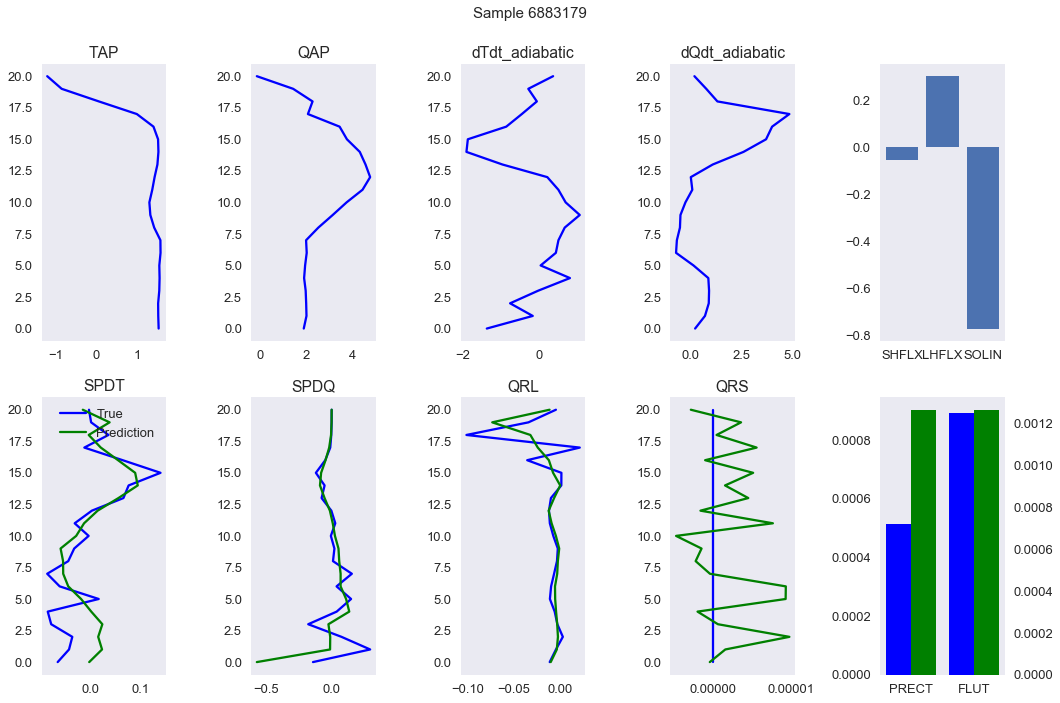

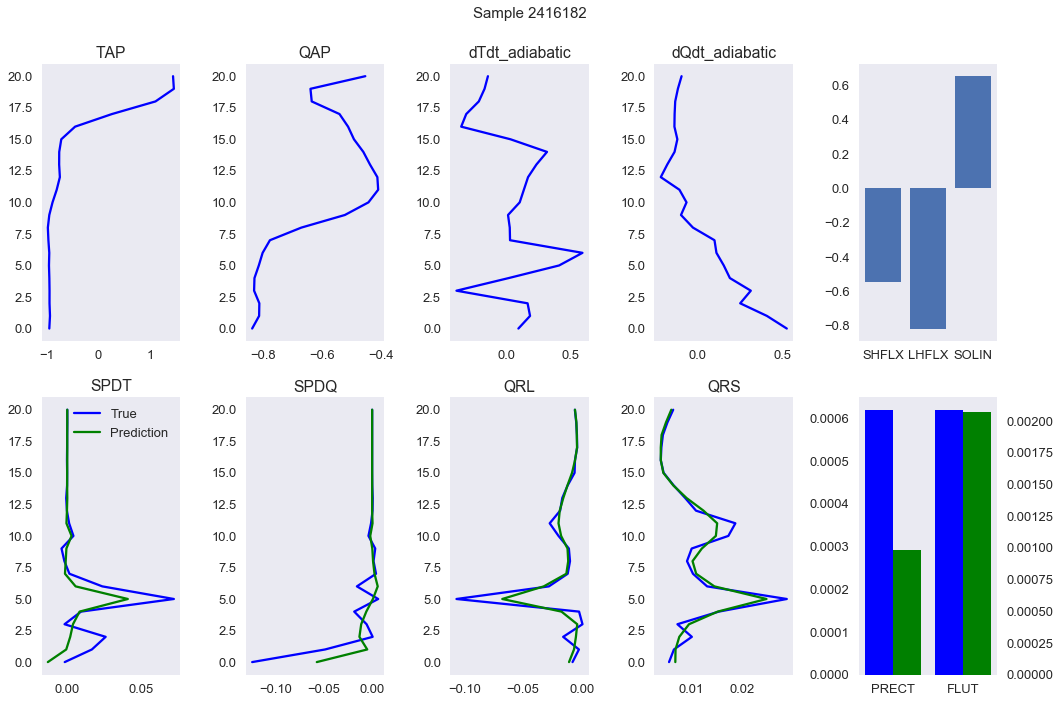

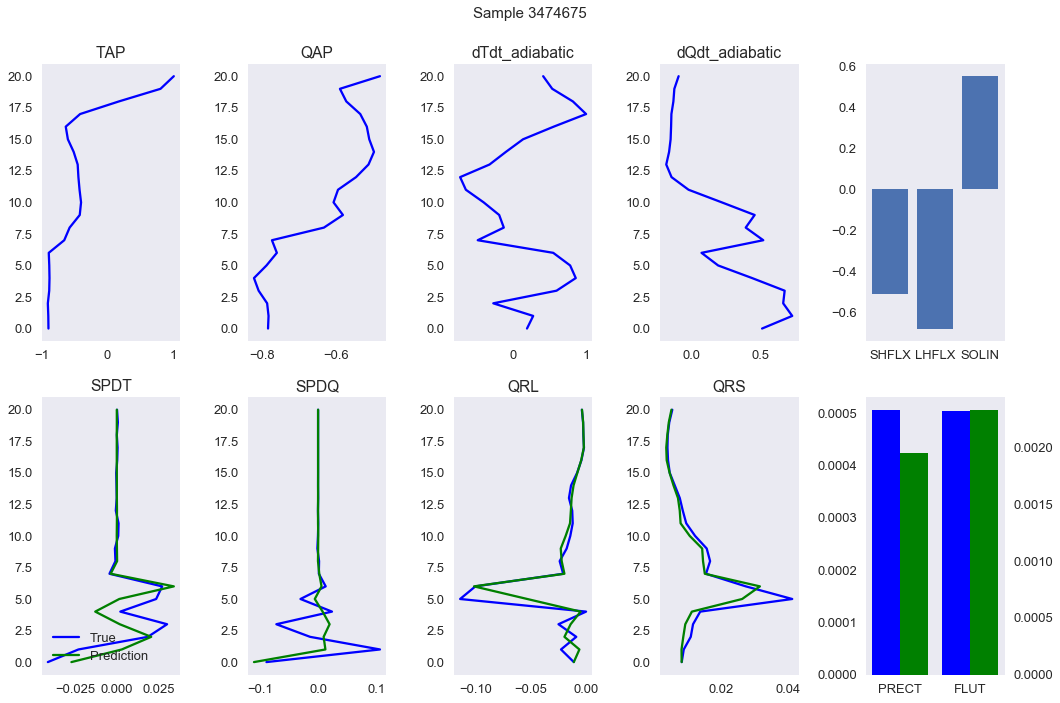

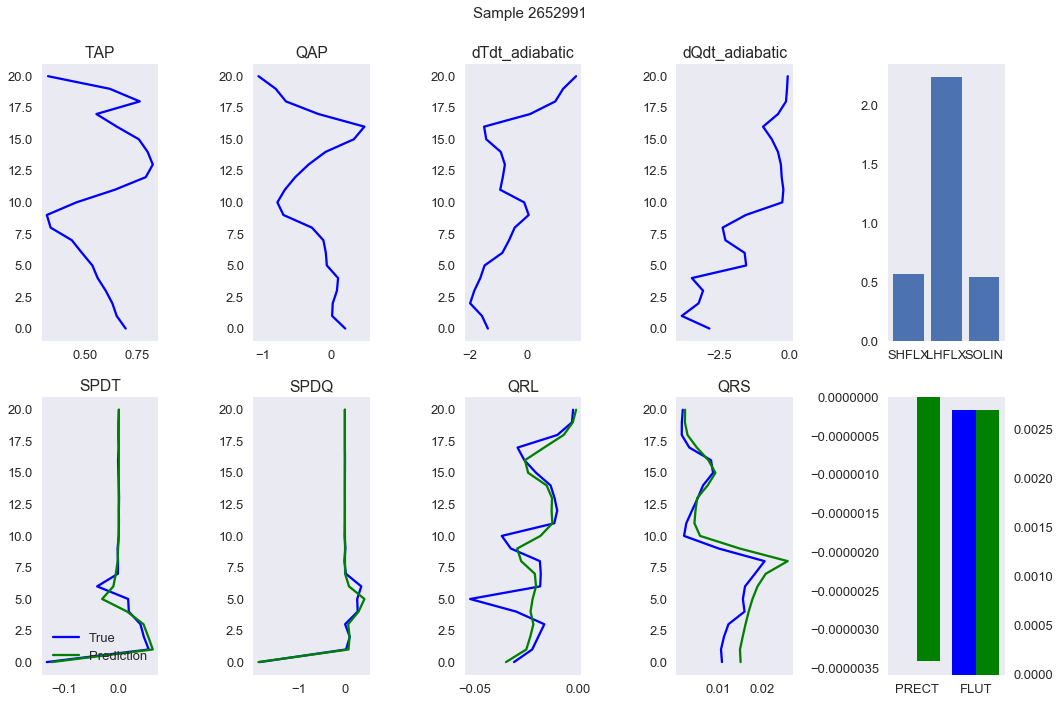

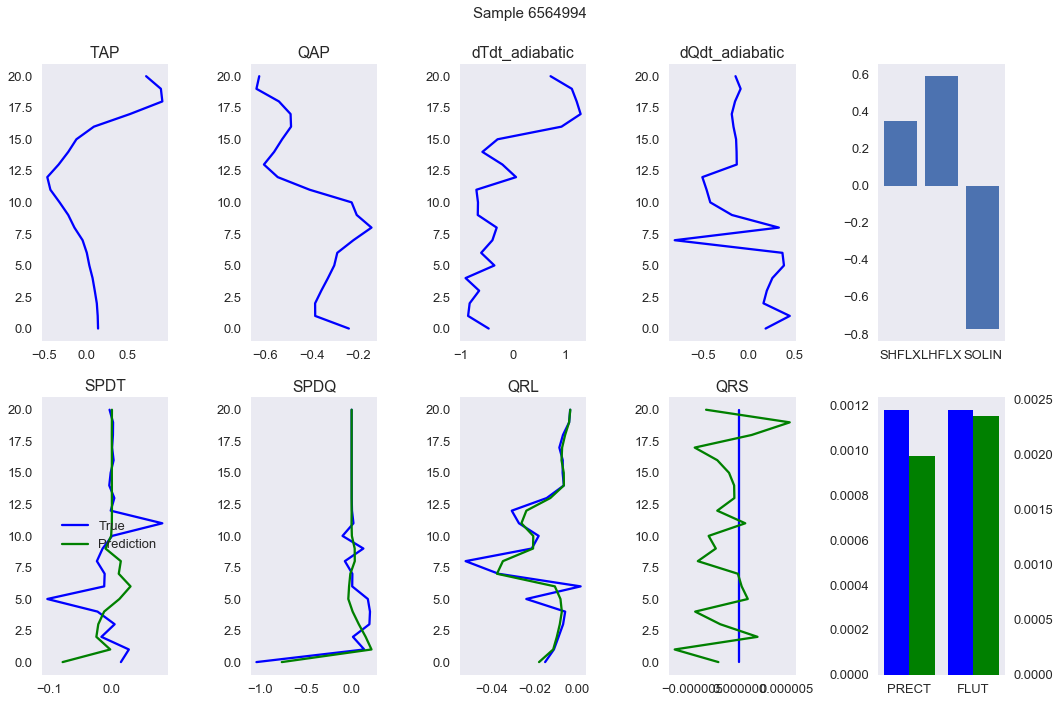

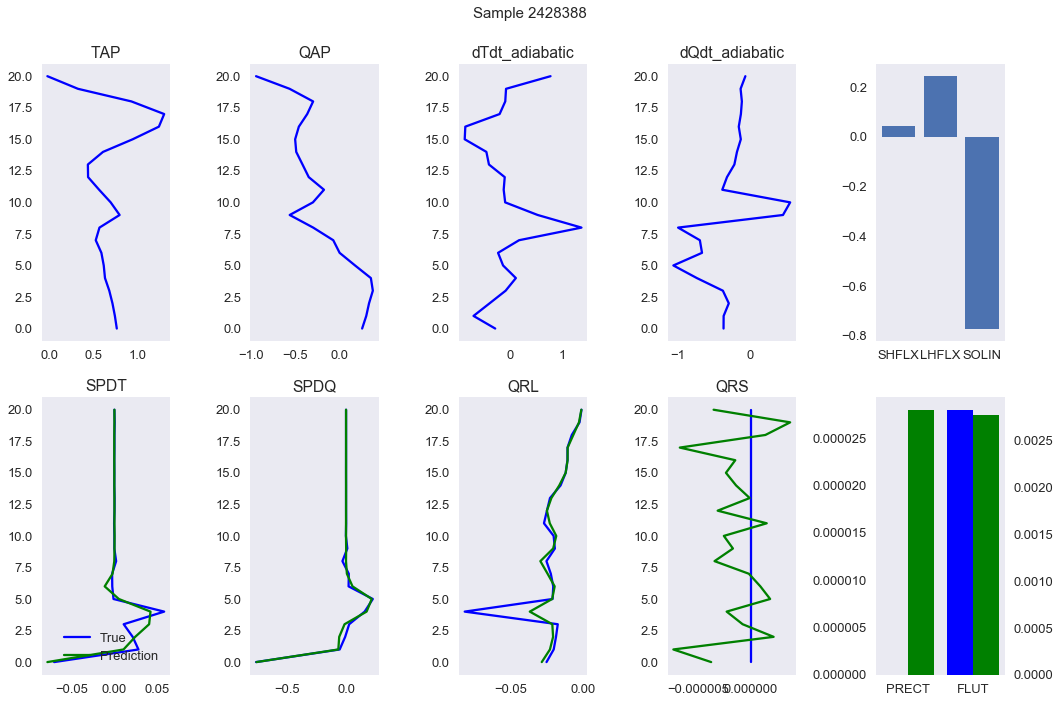

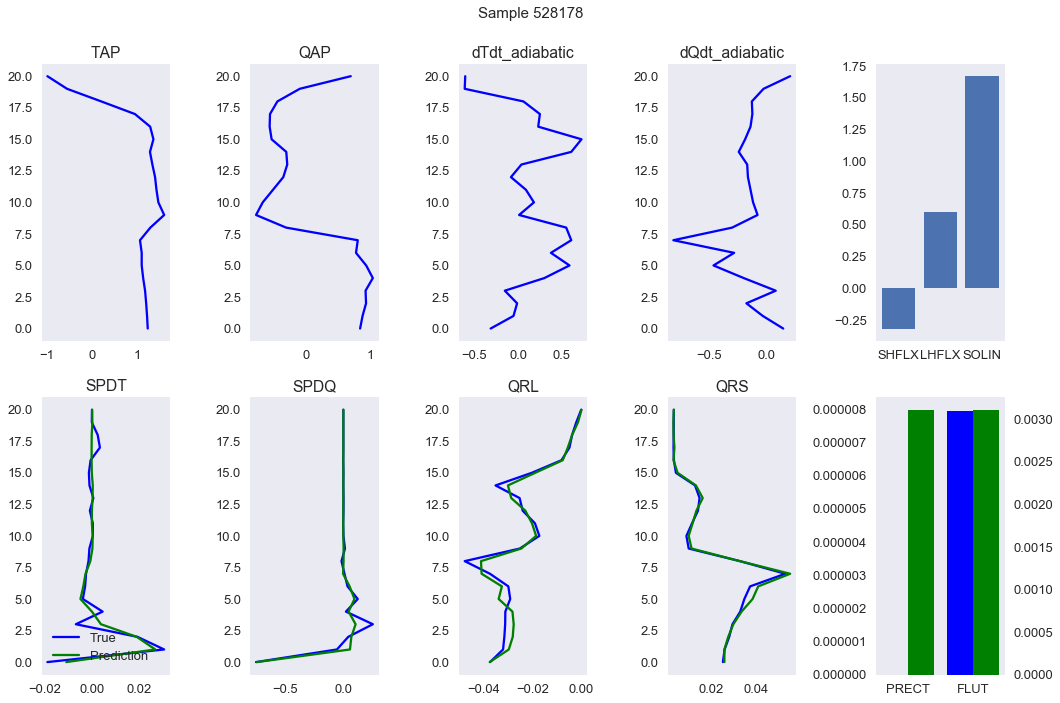

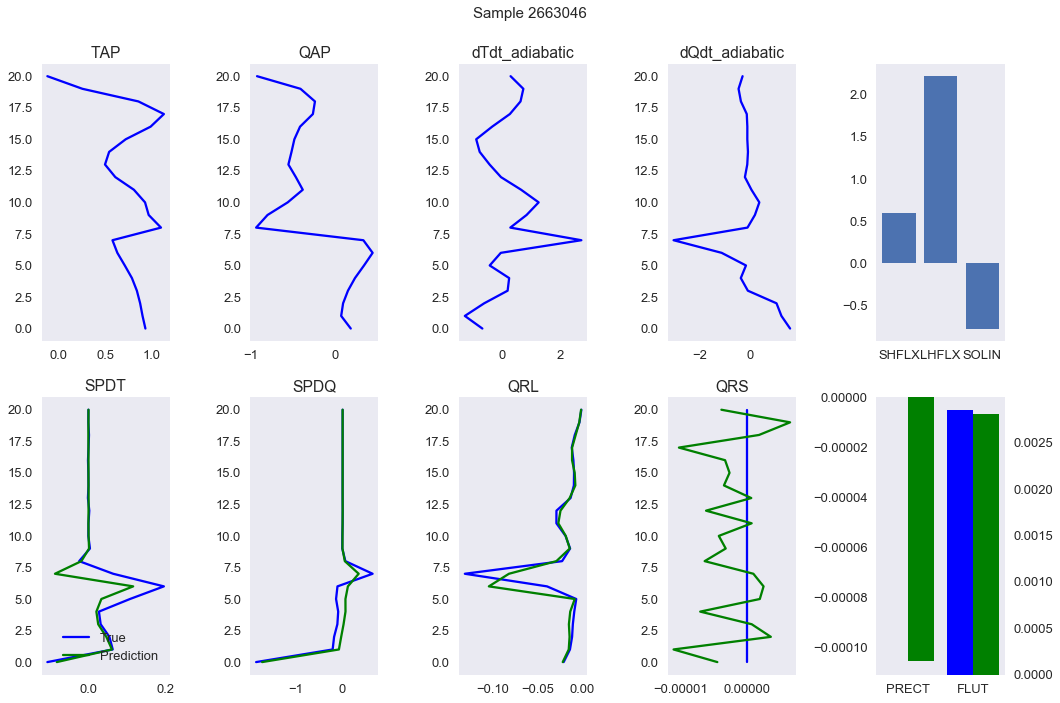

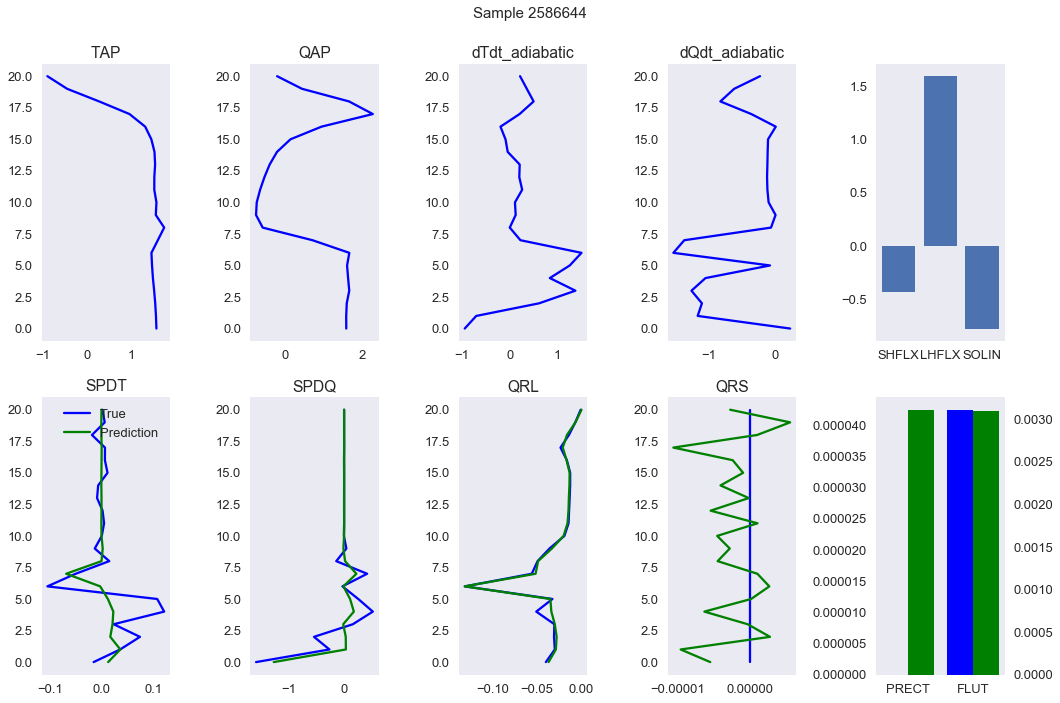

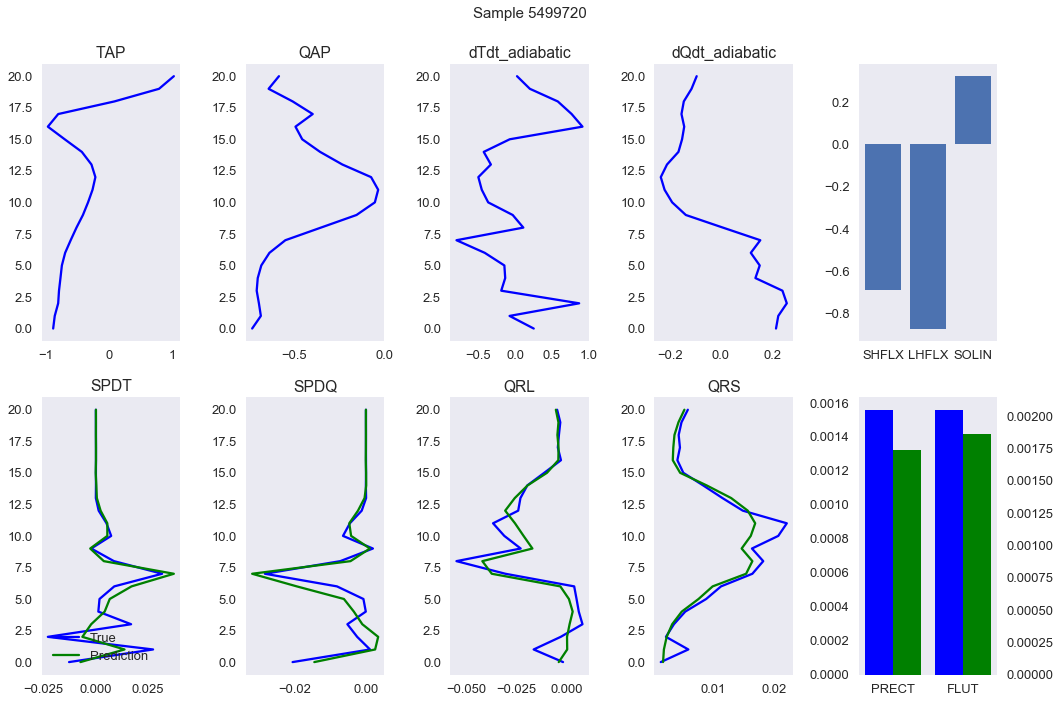

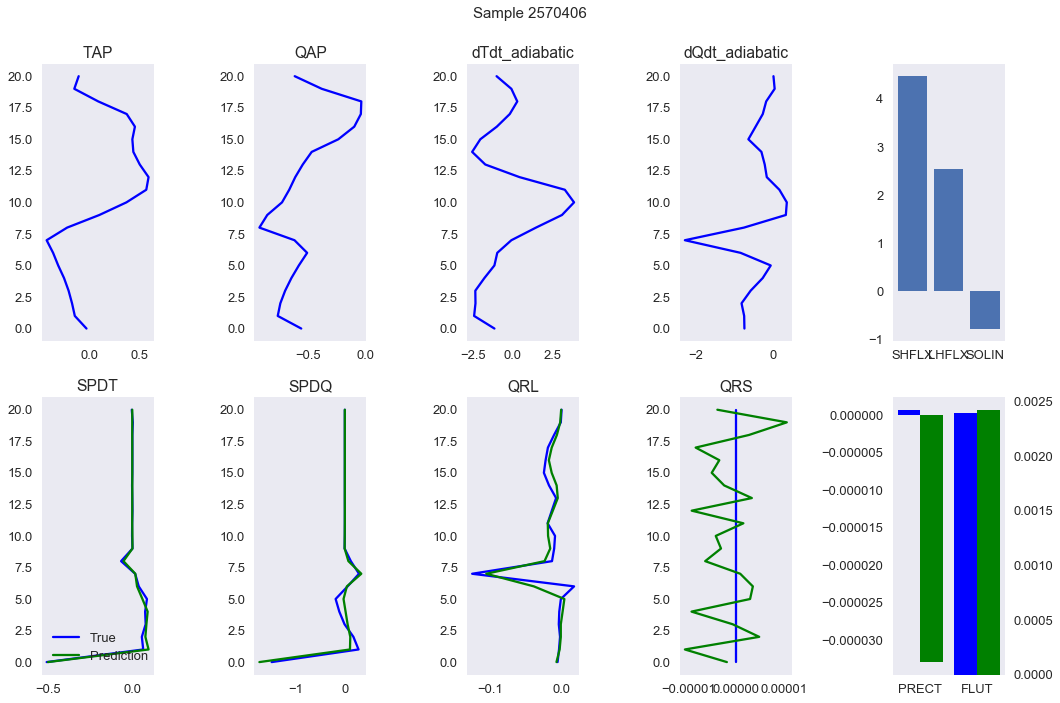

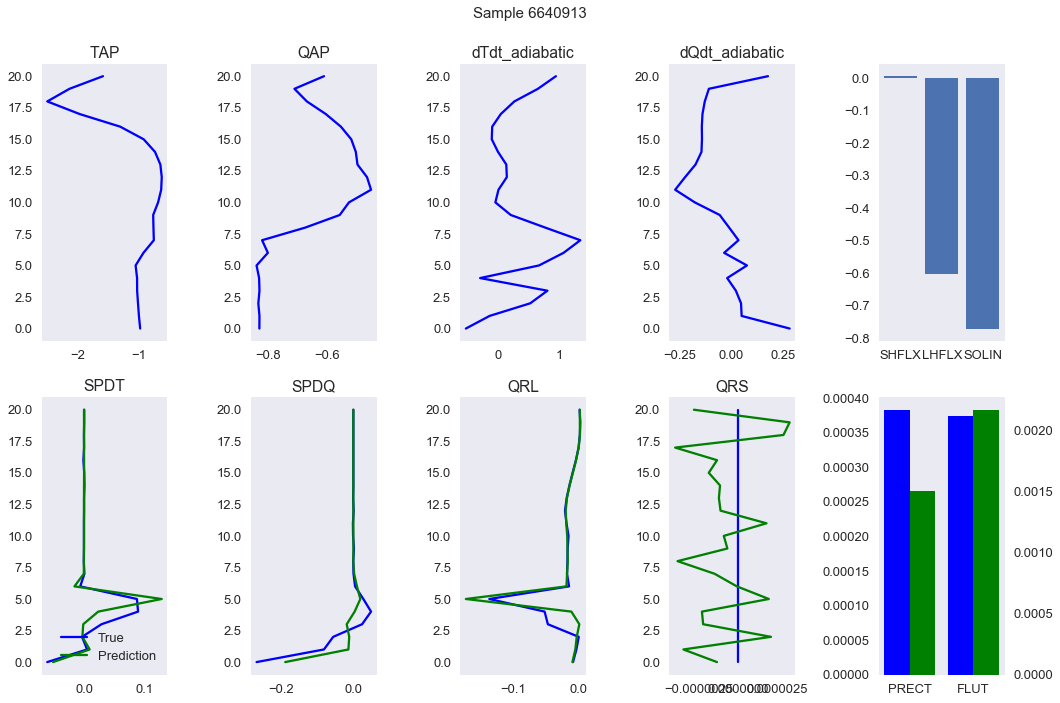

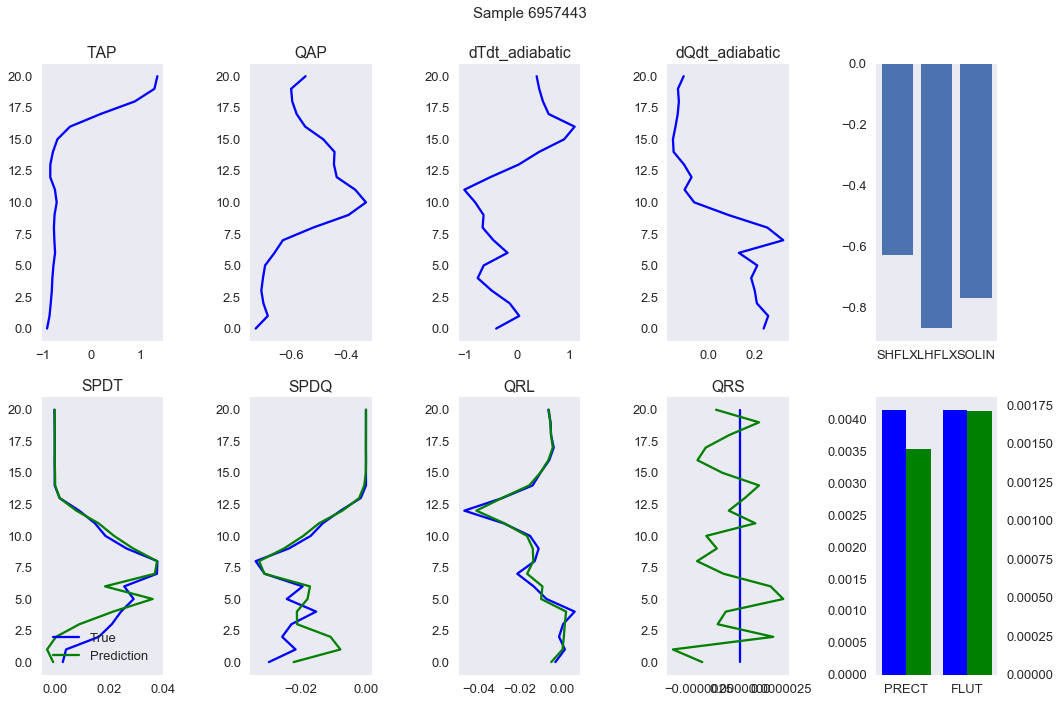

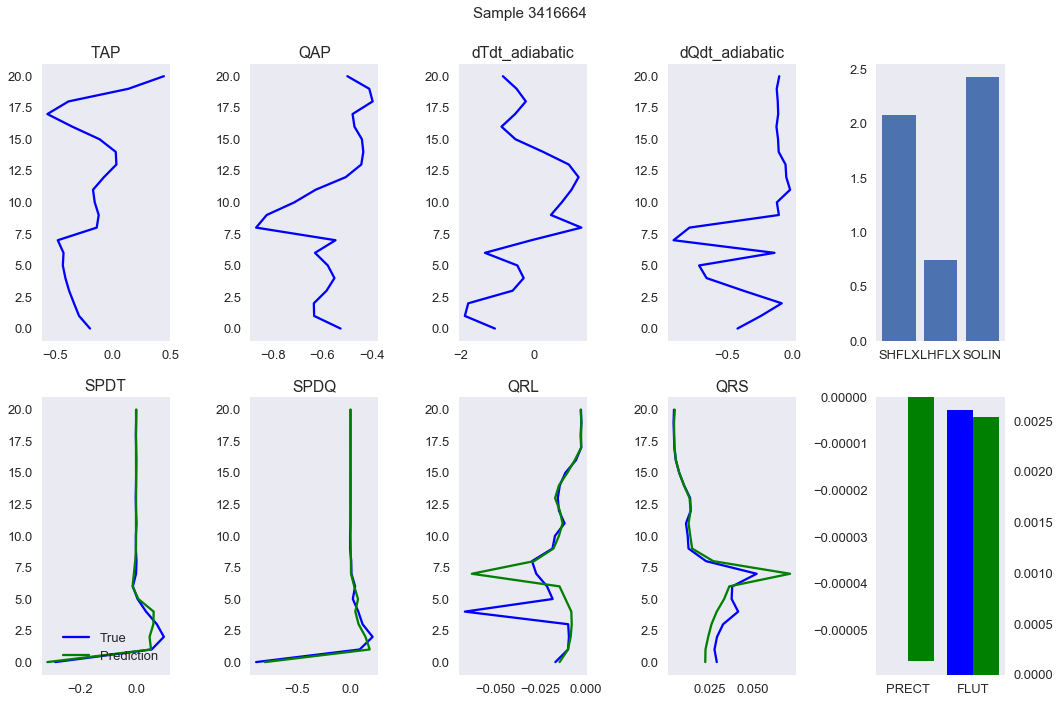

In [28]:
for i in list(np.random.randint(0, valid_set_lon.features.shape[0], 20)):
    vis_features_targets_from_pred2(valid_set_lon.features, 
                                       valid_set_lon.targets, preds,
                                       i, list(valid_set_lon.feature_names), 
                                       list(valid_set_lon.target_names))

Some things I noticed:
- Precipitation can go negative. It is also very non-gaussian. A good transformation would be beneficial probably. Or a different final activation function (why not relu?)
- The OLR (=FLUT) is actually pretty constant, so here a mean-std normalization would potentially be useful

Note that this is only trained with 3 months of data and not to full convergence.

### X-Y slices of precipitation and OLR

In [22]:
valid_set_lon.targets.shape[0] / 47 / 26 / 64

90.0

In [24]:
targets_re = np.reshape(valid_set_lon.targets, (90, 47, 64, 26, 86))
preds_re = np.reshape(preds, (90, 47, 64, 26, 86))

In [25]:
def plot_xy(targets_re, preds_re, idate, itime, ifeat):
    feat_name = list(valid_set_lon.target_names)[ifeat]
    fig, axes = plt.subplots(1, 3)
    mn = np.minimum(targets_re[idate, itime, :, :, ifeat], 
                    preds_re[idate, itime, :, :, ifeat]).min()
    mx = np.maximum(targets_re[idate, itime, :, :, ifeat], 
                    preds_re[idate, itime, :, :, ifeat]).max()
    I = axes[0].imshow(targets_re[idate, itime, :, :, ifeat], cmap='inferno_r', vmin=mn, vmax=mx)
    axes[0].set_title('True ' + feat_name)
    fig.colorbar(I, ax=axes[0], shrink=0.4)
    I = axes[1].imshow(preds_re[idate, itime, :, :, ifeat], cmap='inferno_r', vmin=mn, vmax=mx)
    axes[1].set_title('Predicted ' + feat_name)
    fig.colorbar(I, ax=axes[1], shrink=0.4)
    error = preds_re[idate, itime, :, :, ifeat] - targets_re[idate, itime, :, :, ifeat]
    mx_err = np.max(np.abs(error))
    I = axes[2].imshow(error, cmap='bwr', vmin=-mx_err, vmax=mx_err)
    axes[2].set_title('Error ' + feat_name)
    fig.colorbar(I, ax=axes[2], shrink=0.4)
    plt.tight_layout(); plt.show()

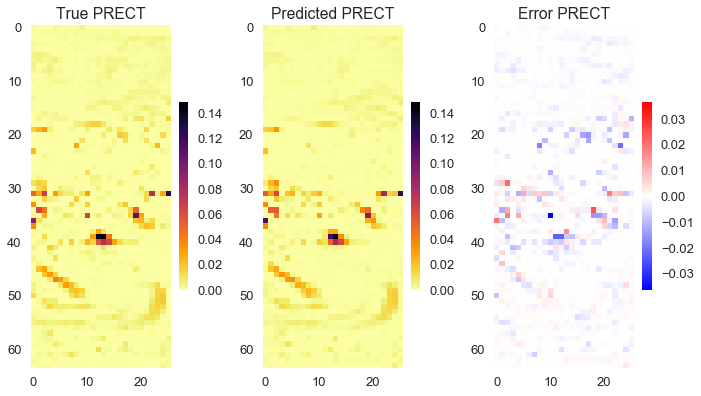

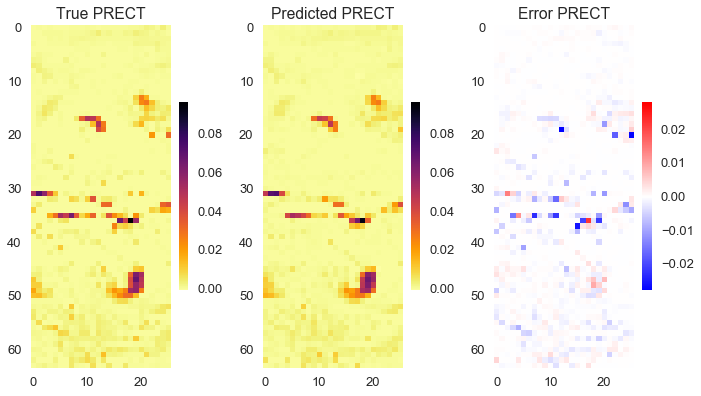

In [26]:
# Just some random plots
plot_xy(targets_re, preds_re, 0, 12, -2)
plot_xy(targets_re, preds_re, 10, 40, -2)

So this actually looks pretty good. What about OLR.

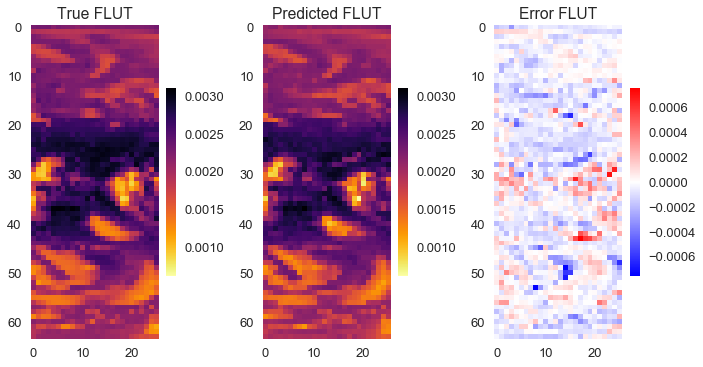

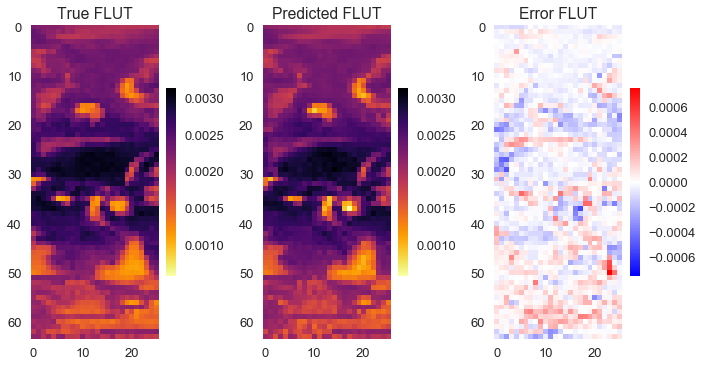

In [27]:
plot_xy(targets_re, preds_re, 0, 12, -1)
plot_xy(targets_re, preds_re, 10, 40, -1)

Also pretty impressive.

In [29]:
def plot_yz(targets, preds, idate, itime, ilon):
    fig, axes = plt.subplots(2, 2, figsize=(13,7))
    range_spdt = np.max(np.abs(targets[idate, itime, :, ilon, :21]))
    range_spdq = np.max(np.abs(targets[idate, itime, :, ilon, 21:42]))
    # Target SPDT
    I = axes[0, 0].imshow(targets[idate, itime, :, ilon, :21].T,
                       vmin=-range_spdt, vmax=range_spdt, cmap='bwr')
    axes[0, 0].set_title('Target SPDT')
    fig.colorbar(I, ax=axes[0, 0], shrink=0.4)
    # Pred SPDT
    I = axes[1, 0].imshow(preds[idate, itime, :, ilon, :21].T,
                       vmin=-range_spdt, vmax=range_spdt, cmap='bwr')
    axes[1, 0].set_title('Predicted SPDT')
    fig.colorbar(I, ax=axes[1, 0], shrink=0.4)
    # Target SPDQ
    I = axes[0, 1].imshow(targets[idate, itime, :, ilon, 21:42].T,
                       vmin=-range_spdq, vmax=range_spdq, cmap='bwr')
    axes[0, 1].set_title('Target SPDQ')
    fig.colorbar(I, ax=axes[0, 1], shrink=0.4)
    # Pred SPDQ
    I = axes[1, 1].imshow(preds[idate, itime, :, ilon, 21:42].T,
                       vmin=-range_spdq, vmax=range_spdq, cmap='bwr')
    axes[1, 1].set_title('Predicted SPDQ')
    fig.colorbar(I, ax=axes[1, 1], shrink=0.4)
    plt.tight_layout()
    plt.show()

Month: 0


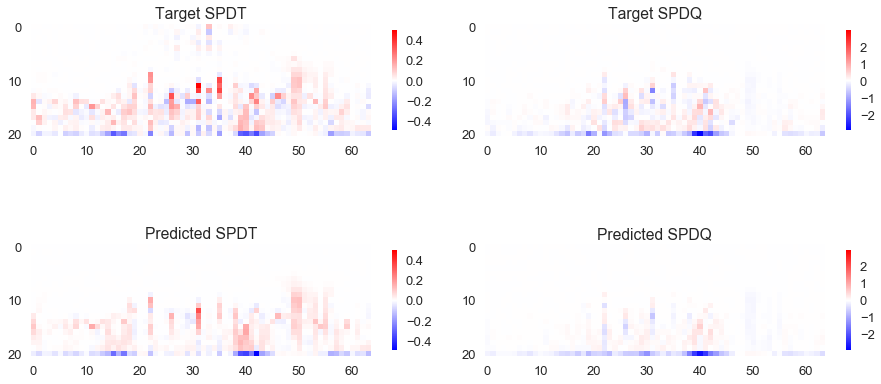

Month: 1


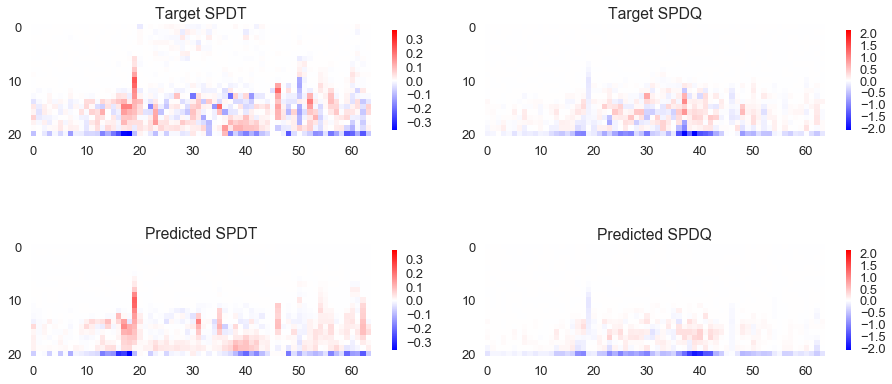

Month: 2


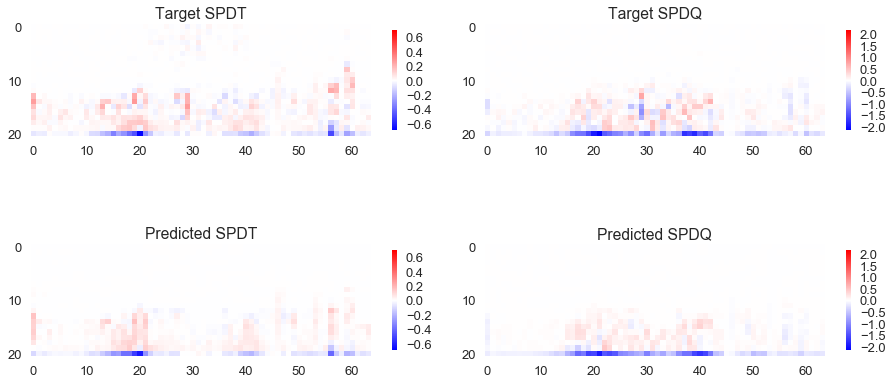

In [31]:
for idate in [0, 1, 2]:
    print('Month:', idate)
    plot_yz(targets_re, preds_re, idate, 24, 10)

So we don't seem to be able to get the extreme values. Could this be related to using the MAE instead of the MSE? 

Also, without the QRL and QRS input the model does not really know where clouds are. This correlates with the fact the the missing extreme values are mostly higher up. I believe that trying out RNNs could be interesting to include some time history.

## Animations

In [322]:
def plot_xy_anim(targets_re, preds_re, ifeat):
    feat_name = list(valid_set_lon.target_names)[ifeat]
    fig, axes = plt.subplots(1, 3)
    fig.set_tight_layout(True)
    mn = np.minimum(targets_re[:, :, :, :, ifeat], 
                    preds_re[:, :, :, :, ifeat]).min()
    mx = np.maximum(targets_re[:, :, :, :, ifeat], 
                    preds_re[:, :, :, :, ifeat]).max()
    # Init
    I0 = axes[0].imshow(targets_re[0, 0, :, :, ifeat], cmap='inferno_r', vmin=mn, vmax=mx)
    axes[0].set_title('True ' + feat_name)
    fig.colorbar(I0, ax=axes[0], shrink=0.4)
    I1 = axes[1].imshow(preds_re[0, 0, :, :, ifeat], cmap='inferno_r', vmin=mn, vmax=mx)
    axes[1].set_title('Predicted ' + feat_name)
    fig.colorbar(I1, ax=axes[1], shrink=0.4)
    error = preds_re[:, :, :, :, ifeat] - targets_re[:, :, :, :, ifeat]
    mx_err = np.max(np.abs(error))
    I2 = axes[2].imshow(error[0, 0], cmap='bwr', vmin=-mx_err, vmax=mx_err)
    axes[2].set_title('Error ' + feat_name)
    fig.colorbar(I2, ax=axes[2], shrink=0.4)
    fig.suptitle('Day: %i -  Hour: %.1f' % (0, 0))
    
    # Update function
    def update(i):
        idate = int(np.floor(i / 47.))
        itime = (i - idate * 47) % 47
        I0.set_data(targets_re[idate, itime, :, :, ifeat])
        I1.set_data(preds_re[idate, itime, :, :, ifeat])
        I2.set_data(error[idate, itime])
        fig.suptitle('Day: %i -  Hour: %.1f' % (idate, itime / 2.))
        return (I0, I1, I2)
    
    return FuncAnimation(fig, update, frames=np.arange(47*12), interval=100, blit=True)

/home/s/S.Rasp/.conda/envs/cbrain_gpu/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


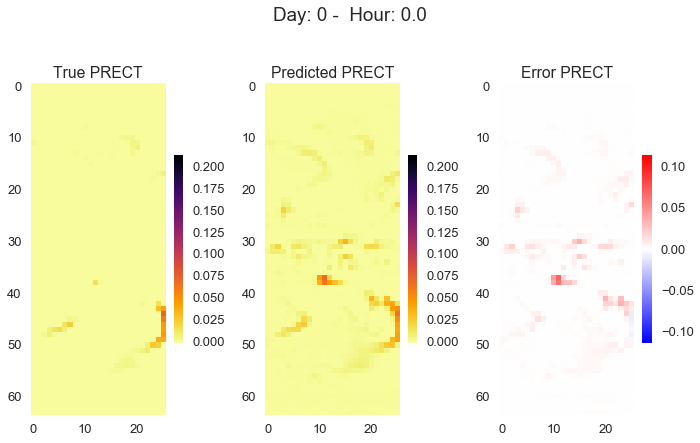

In [323]:
anim = plot_xy_anim(targets_re, preds_re, -2)

In [324]:
HTML(anim.to_html5_video())

In [325]:
anim.save('/home/s/S.Rasp/tmp/PRECT_animation.mp4', dpi=80)

/home/s/S.Rasp/.conda/envs/cbrain_gpu/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


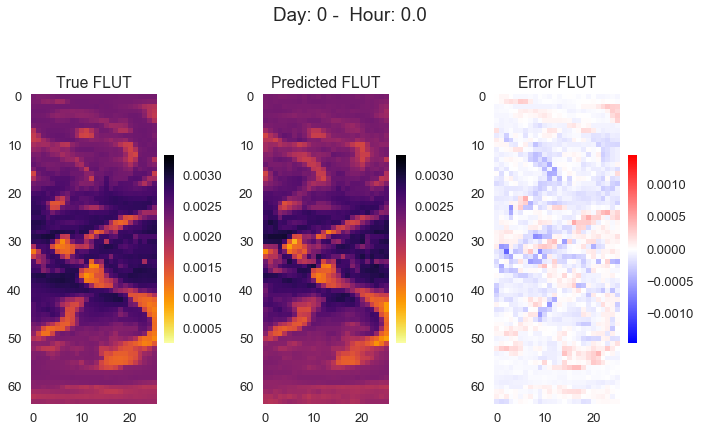

In [326]:
anim = plot_xy_anim(targets_re, preds_re, -1)

In [327]:
HTML(anim.to_html5_video())

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [328]:
anim.save('/home/s/S.Rasp/tmp/OLR_animation.mp4', dpi=80)